In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fast-food/FastFoodNutritionMenuV2.csv


# First Look
Now that the standard Kaggle import is done, let's open the file and look at it a bit

Note that is it a modified/updated version of my "Fast Food with heavy cleanup" notebook, using the new filepath & removing some of the cleanup steps that the prior version of the dataset required. If you want to see what the problems with the older version of the dataset were & how I fixed them, you can go to that notebook and/or see the discussion topic about this for this dataset.

In [2]:
import warnings
warnings.simplefilter('ignore')

#load file
file = pd.read_csv('/kaggle/input/fast-food/FastFoodNutritionMenuV2.csv')

#exploratory examination of file
display(file.head())
file.info()
#file.isna().sum()

,Company,Item,Calories,Calories from\nFat,Total Fat\n(g),Saturated Fat\n(g),Trans Fat\n(g),Cholesterol\n(mg),Sodium \n(mg),Carbs\n(g),Fiber\n(g),Sugars\n(g),Protein\n(g),Weight Watchers\nPnts
0,McDonald’s,Hamburger,250,80,9,3.5,0.5,25,520,31,2,6,12,247.5
1,McDonald’s,Cheeseburger,300,110,12,6,0.5,40,750,33,2,6,15,297
2,McDonald’s,Double Cheeseburger,440,210,23,11,1.5,80,1150,34,2,7,25,433
3,McDonald’s,McDouble,390,170,19,8,1,65,920,33,2,7,22,383
4,McDonald’s,Quarter Pounder® with Cheese,510,230,26,12,1.5,90,1190,40,3,9,29,502


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1148 entries, 0 to 1147
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Company               1148 non-null   object
 1   Item                  1148 non-null   object
 2   Calories              1147 non-null   object
 3   Calories from
Fat     642 non-null    object
 4   Total Fat
(g)         1091 non-null   object
 5   Saturated Fat
(g)     1091 non-null   object
 6   Trans Fat
(g)         1091 non-null   object
 7   Cholesterol
(mg)      1147 non-null   object
 8   Sodium 
(mg)          1147 non-null   object
 9   Carbs
(g)             1091 non-null   object
 10  Fiber
(g)             1091 non-null   object
 11  Sugars
(g)            1147 non-null   object
 12  Protein
(g)           1091 non-null   object
 13  Weight Watchers
Pnts  887 non-null    object
dtypes: object(14)
memory usage: 125.7+ KB


# Converting columns to numeric: checking what doesn't fit
All columns except Company / Item should be numeric (I will use float type) but are currently object type, so we will need to eventually convert them to float.

At the same time, I also want to know what is in my columns that aren't numeric, so I wrote a function that will reveal what kinds of values cannot be converted to float in each of these columns, so that I can see what other cleaning steps might be used to salvage data / determine whether other errors may be present:

In [3]:
def df_non_numeric_list(dataframe,column_exclusion_list=None):
    """ Print all unique values in a dataframe, by column, that cannot be converted to a float.
    
    Parameters
    ----------
    dataframe (pandas dataframe): required, the dataframe whose columns are to be analyzed for non-numeric convertible values
    column_exclusion_list (list): optional, a list of column names of those columns to be excluded from the analysis. Default value is None.
    
    Returns
    -------
    Prints: the name of each column in the dataframe, followed by a list of all the non-numeric convertible values in the column.
    """
    for column in dataframe.columns:
        error_list = []
        if column in column_exclusion_list:
            pass
        else:
            for element in dataframe[column]:
                try:
                    element_float = float(element)
                except:
                    error_list.append(element)
            print(column , ': ', pd.Series(error_list).unique())

#Check what non-numerics are hiding in the columns that ought to be numeric....
df_non_numeric_list(file,['Company','Item'])


Calories :  ['\xa0']
Calories from
Fat :  ['\xa0']
Total Fat
(g) :  ['\xa0']
Saturated Fat
(g) :  ['5.5 g' '\xa0']
Trans Fat
(g) :  ['\xa0']
Cholesterol
(mg) :  ['\xa0' '<5']
Sodium 
(mg) :  ['\xa0' '<1']
Carbs
(g) :  ['\xa0' '<1']
Fiber
(g) :  ['\xa0' '<1']
Sugars
(g) :  ['\xa0' '<1']
Protein
(g) :  ['\xa0']
Weight Watchers
Pnts :  ['\xa0']


# Fixing non-numeric values in the numerical columns
I found that the values in a non numeric-convertable form were either:
  
  
  '\xa0', 
 
 
 '<1' or '<5', 
 
 
 plus one instance where the units were included with a usable number ('5.5 g')

In [4]:
#Simple cleaning
#Step 1: clean the '5.5g' data point in the saturated fat column
file['Saturated Fat\n(g)'] = file['Saturated Fat\n(g)'].str.replace('5.5 g','5.5')

#Step 2: convert all '\xa0' to NaN and all '<1' / '<5' to 0:
file_no_company_item = file.drop(['Company','Item'],axis=1)
for i in file_no_company_item.columns:
    change_list = []
    for j in file[i]:
        if j == '\xa0':
            change_list.append(np.nan)
        elif (j == '<1') | (j == '<5'):
            change_list.append(0)
        else:
            change_list.append(j) 
    file[i] = pd.Series(change_list)

#Confirm that the '<1','<5', and '5.5 g' are no longer in the dataframe using my previously defined function:
print('After fixing a number of the non-convertible items in the numeric columns: re-test to confirm they have been fixed: \n')
df_non_numeric_list(file,['Company','Item'])

#convert to float
file_no_company_item = file.drop(['Company','Item'],axis=1)
f_cols = file_no_company_item.columns
for i in f_cols:
    file = file.astype({i : 'float'})

#check for duplicates, and remove (there are 7 duplicates, just like I saw another notebook find)
print(len(file))
file = file.drop_duplicates()
print(len(file))

#remove all rows where every value is NaN (except company/item). 
file_company_item_only = file[['Company','Item']]
file_company_item_only_index = set(file.index)

file = file.dropna(subset = file_no_company_item.columns, how='all')

#check NaN's again
print("\n I've also removed some of the NaN's, but some remain")
#print(file.isna().sum(), len(file))

After fixing a number of the non-convertible items in the numeric columns: re-test to confirm they have been fixed: 

Calories :  []
Calories from
Fat :  []
Total Fat
(g) :  []
Saturated Fat
(g) :  []
Trans Fat
(g) :  []
Cholesterol
(mg) :  []
Sodium 
(mg) :  []
Carbs
(g) :  []
Fiber
(g) :  []
Sugars
(g) :  []
Protein
(g) :  []
Weight Watchers
Pnts :  []
1148
1141

 I've also removed some of the NaN's, but some remain


# Addressing the remaining Null values in the DataFrame
Now I will drop all the NaN's (there are relatively few, less than 5% of the rows in the dataframe) except the NaN's in the Weight Watchers Points column, which I'll leave as is, and the NaN's in the Calories from Fat column, which I will impute using the approximate of 9 calories / gram of fat. 

The Weight Watchers column, from what I have seen, is exclusively NaN for some companies (so I didn't want to impute a mean WW Points to those), but as we'll see later, the WW Points column does not convey much useful information beyond the information already captured by the Total Calories column of the dataframe (the two values correlate at 0.99!). 

In [5]:
#print(file.isna().sum(), len(file))

# first, I will drop all the rows with NaNs below 5% of the columns (which is ~56, from 0.05*1126)
#then fill all the NaN's of the calories from fat with 9*total fat
# finally I will choose to bot impute the NaN's in the Weight Watchers column, as three of the companies simply have no data for that
cols_to_drop_NaN = ['Total Fat\n(g)','Saturated Fat\n(g)','Trans Fat\n(g)','Carbs\n(g)','Fiber\n(g)','Protein\n(g)']
file = file.dropna(subset=cols_to_drop_NaN)
file['Calories from\nFat'] = file['Calories from\nFat'].fillna(9 * file['Total Fat\n(g)'])

#print(file_reforged.isna().sum(), len(file_reforged))  
print('Have dropped all nulls except those in the Weight Watcher Points column: \n')
print(file.isna().sum())
# I can see the changes have taken effect -- now it time to finally plot something / move past data cleaning!

Have dropped all nulls except those in the Weight Watcher Points column: 

Company                    0
Item                       0
Calories                   0
Calories from\nFat         0
Total Fat\n(g)             0
Saturated Fat\n(g)         0
Trans Fat\n(g)             0
Cholesterol\n(mg)          0
Sodium \n(mg)              0
Carbs\n(g)                 0
Fiber\n(g)                 0
Sugars\n(g)                0
Protein\n(g)               0
Weight Watchers\nPnts    203
dtype: int64


# First Look at data: distribution of numerical variables

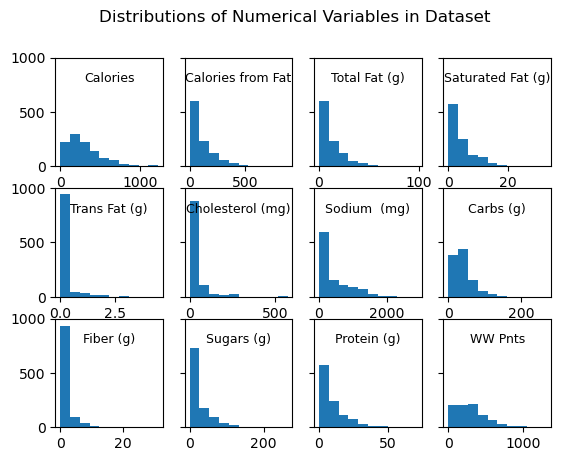

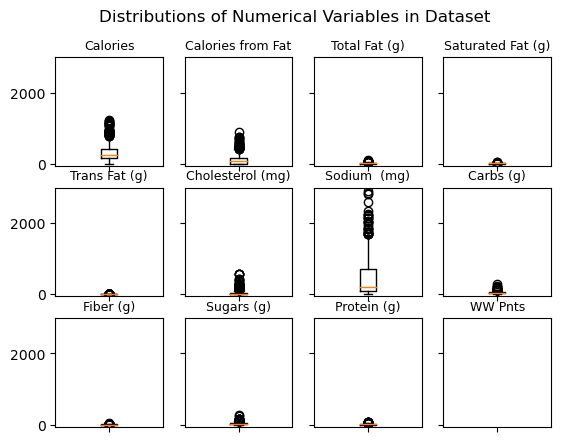

In [6]:
#time to look at the data for things of interest!
#But first, let's look at outliers

import matplotlib.pyplot as plt
import seaborn as sns

#Distributions of all the numerical data in the dataset

fig,ax = plt.subplots(nrows = 3,ncols = 4,sharey=True)
col = 2
for axs in ax.flat:
    axs.hist(file.iloc[:,col])
    axs.set_title(file.columns[col].replace('\n',' ').replace('Weight Watchers','WW'),size = 9,y = 0.7)
    axs.set_ylim(top = 1000)
    col += 1
fig.suptitle("Distributions of Numerical Variables in Dataset")
plt.show()

#boxplot
fig,ax = plt.subplots(nrows = 3,ncols = 4,sharey=True)
col = 2
for axs in ax.flat:
    axs.boxplot(file.iloc[:,col])
    axs.set_title(file.columns[col].replace('\n',' ').replace('Weight Watchers','WW'),size = 9,y = 1.0)
    axs.set_ylim(top = 3000)
    axs.set_xticklabels('')
    col += 1
fig.suptitle("Distributions of Numerical Variables in Dataset")
plt.show()

# Potentially useful Transformation: cubed-root

With the except of the total calories and WW pnts columns, the distributions visible above are very right-skewed and have lots of values piled up near 0 with large tails of higher-value outliers, so a transformation of the data may be useful. 

I tried a log-transformation first, but settled on a root transformation because the many zero values in the dataset (even with the addition of a small number like 0.0001 to avoid infinities) seemed to throw off the output for some of the downstream analysis I was doing. A cubed-root ended up being simpler to execute and appeared to convert the data to relatively normal distributions for most columns, except for the pile of values remaining at 0 in many of them:

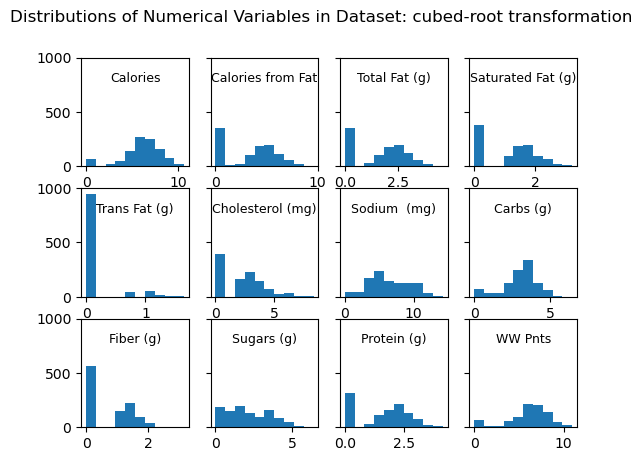

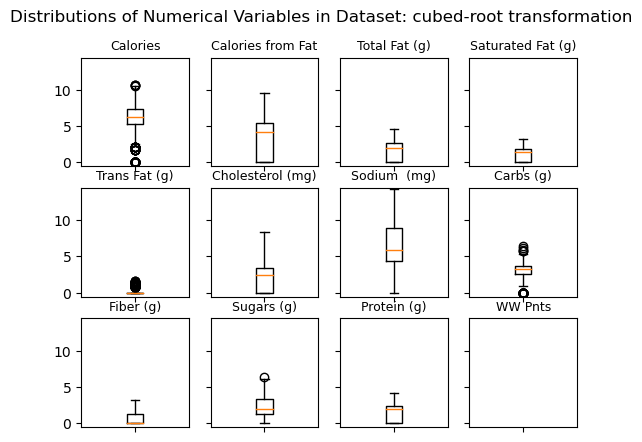

In [7]:
#Most of these are heavily right-skewed distributions, so let's transform them by taking the cubed root and see what happens:
file_re_trans = pd.DataFrame()
for i in file_no_company_item.columns:
    file_re_trans[i] = (file[i]) ** (1/3)

#Distributions of all the numerical data in the transformed dataset

fig,ax = plt.subplots(nrows = 3,ncols = 4,sharey=True)
col = 0
for axs in ax.flat:
    axs.hist(file_re_trans.iloc[:,col])
    axs.set_title(file_re_trans.columns[col].replace('\n',' ').replace('Weight Watchers','WW'),size = 9,y = 0.7)
    axs.set_ylim(top = 1000)
    col += 1
fig.suptitle("Distributions of Numerical Variables in Dataset: cubed-root transformation")
plt.show()

#boxplot
fig,ax = plt.subplots(nrows = 3,ncols = 4,sharey=True)
col = 0
for axs in ax.flat:
    axs.boxplot(file_re_trans.iloc[:,col])
    axs.set_title(file_re_trans.columns[col].replace('\n',' ').replace('Weight Watchers','WW'),size = 9,y = 1.0)
    axs.set_ylim(top = (3000 **(1/3)))
    axs.set_xticklabels('')
    col += 1
fig.suptitle("Distributions of Numerical Variables in Dataset: cubed-root transformation")
plt.show()
    

# Distributions of calories, sodium, and fiber by company

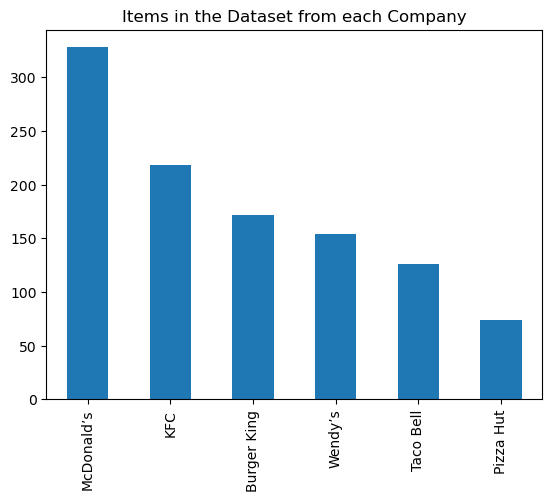

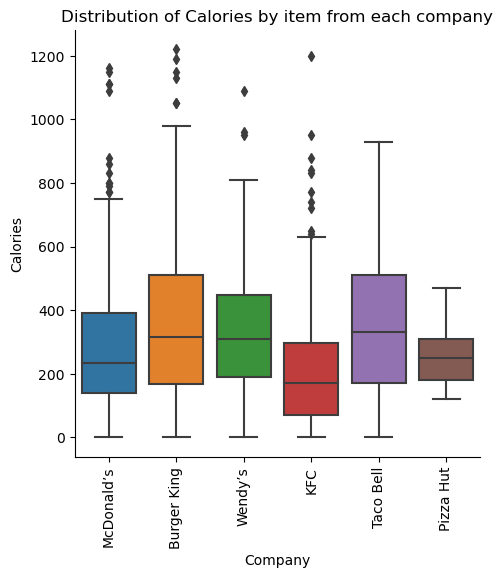

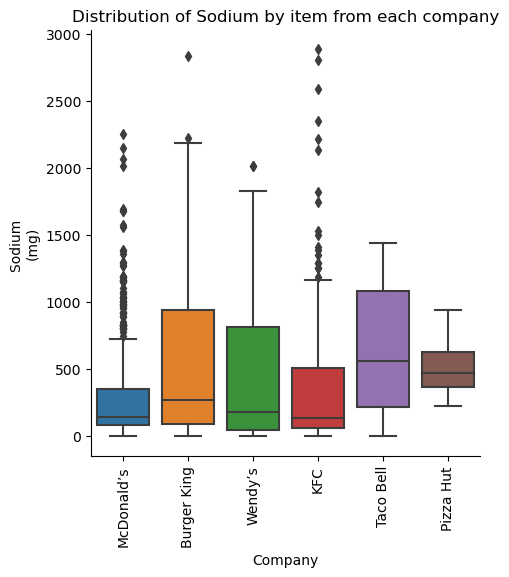

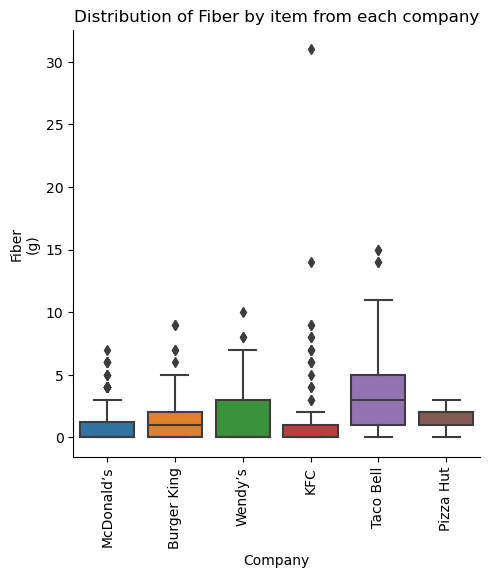

In [8]:
#Much better! If called for, we can always use a cubed-root transformation, but the transformed dataframe currently doesn't have the first two columns: 
file_re_trans['Company'] = file['Company']
file_re_trans['Item'] = file['Item']

#Although there are still some outliers in the data, I want to move on to visualization and analysis for now 

#The question is -- what do we what to know?
#I see other have split things up by company, so I'll look at that too
file['Company'].value_counts().plot(kind='bar')
plt.title("Items in the Dataset from each Company")
plt.show()

sns.catplot(kind='box',data=file,x='Company',y='Calories')
plt.xticks(rotation = 90)
plt.title("Distribution of Calories by item from each company")
plt.show()

sns.catplot(kind='box',data=file,x='Company',y='Sodium \n(mg)')
plt.xticks(rotation = 90)
plt.title("Distribution of Sodium by item from each company")
plt.show()

sns.catplot(kind='box',data=file,x='Company',y='Fiber\n(g)')
plt.xticks(rotation = 90)
plt.title("Distribution of Fiber by item from each company")
plt.show()

In [9]:
''' 
#but I also want to know about how many items are of different levels of calories, like sauces with very low calories, perhaps. I might use these later.
xlow_cal = file[file['Calories'] <= 50]

#could be good to exclude very low calorie items:
#cal_more_than_50 = file[file['Calories'] > 50]

low_cal = file[(file['Calories'] <= 150)  & (file['Calories'] > 50)]
med_cal = file[(file['Calories'] <= 450)  & (file['Calories'] > 150)]
high_cal = file[file['Calories'] > 450]
listy = [xlow_cal,low_cal,med_cal,high_cal]
title_list=['<50','50-150','150-450','>450']
#print(low_cal,len(low_cal))
for ii,i in enumerate(listy):
    corr = i.corr()
    sns.heatmap(corr,annot=True,linewidth=0.5,fmt = '0.2f')
    plt.title('Correlations of {} calorie items'.format(title_list[ii]))
    plt.show()
'''
print('Uncomment code, or run directly by highlight --> ctrl+shift+enter for a lot of heatmaps across the various categories of calorie content')

Uncomment code, or run directly by highlight --> ctrl+shift+enter for a lot of heatmaps across the various categories of calorie content


# Correlation visualizations

Let's see how the columns correlate with each other. This will also be useful for any downstream machine learning analysis, as we will be able to drop redundant columns.

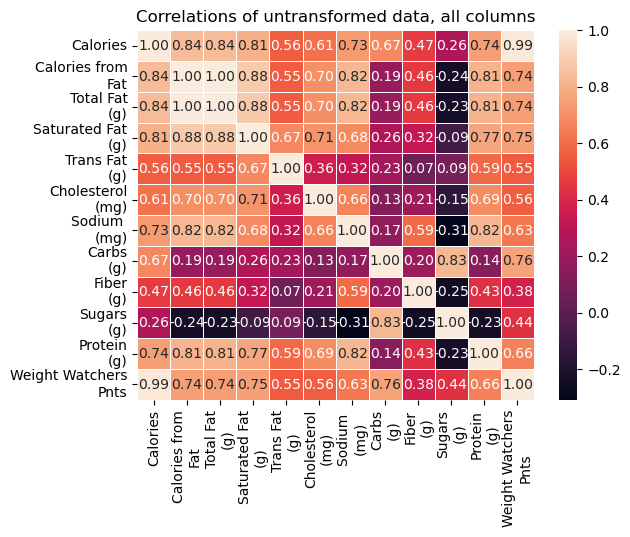

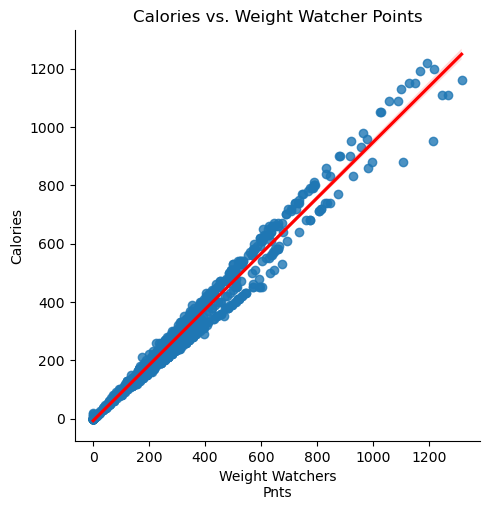

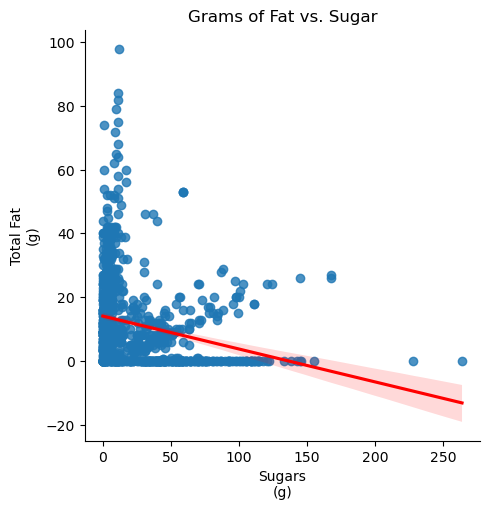

In [10]:

#Let's see if we can predict company from the characteristics of the items:
#First let's find highly correlated data and drop redundant/correlated columns
corr = file.corr()
sns.heatmap(corr,annot=True,linewidth=0.5,fmt = '0.2f')
plt.title('Correlations of untransformed data, all columns')
plt.show()


#almost all of the columns values are positively correlated (if weakly) with each other, except sugar

#some correlation comparisons

#Is the weight Watchers column just a proxy for total calories? will drop NaN rows
file_WW_comp = file.dropna(subset = 'Weight Watchers\nPnts')

sns.lmplot(data=file_WW_comp, x = 'Weight Watchers\nPnts',y = 'Calories',line_kws={'color':'r'})
plt.title('Calories vs. Weight Watcher Points')
plt.show()

#Fat vs. Sugar
sns.lmplot(data=file, x = 'Sugars\n(g)',y = 'Total Fat\n(g)',line_kws={'color':'r'})
plt.title('Grams of Fat vs. Sugar')
plt.show()




# Conclusion of correlation visualizations:
We can see that most measured values in the dataset correlate with each other positively, except sugar.
Interestingly, when we look at the scatter plot of sugar vs. fat quantities, we can see that the negative correlation is driven by a large number of items that are either predominantly fat with no sugar, or vice versa, seen by the points tightly hugging the x and y axes in the final figure of this section.

Another point of interest is that the "Weight Watchers Points" is extremely tightly correlated with total calories (correlation = 0.99), perhaps indicating that the Weight Watcher Points system is not contributing additional information about fast food items beyond total calorie count.



# Can we predict the company from the item characteristics?

Perhaps we can use machine learning to train an algorithm to identify the company name from the nutrient characteristics of the item.

In [11]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import xgboost as xgb


#preparefile

#print(file_re_trans.columns)  -- remembering the column names this deep in the notebook is easier if you print them...

#all the fat columns & Cholesterol are highly correlated, drop all except Total Fat
file_drop = file_re_trans.drop(['Saturated Fat\n(g)','Calories from\nFat','Cholesterol\n(mg)'],axis = 1)
#Weight Watcher points correlates extremely closely with total calories, also was imputed for half of the companies in the dataset,: also drop
file_drop = file_drop.drop(['Weight Watchers\nPnts'],axis = 1)

#let's do this only for the items > 50 Calories:
file_drop = file_drop[file_drop['Calories'] > (50**(1/3))]

SEED = 656

X = file_drop.drop(['Item','Company'],axis = 1)

y = file_drop['Company']
y = y.factorize()
y = y[0]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25,random_state = SEED)

#let's see if we can identify companies from their items
sc = StandardScaler()
xg = xgb.XGBClassifier(objective = "reg:linear",random_state=SEED)
param = {"max_depth":[10,20,30],'n_estimators':[10,20,30],'gamma':[0.05,0.15,0.3]}
cv = GridSearchCV(xg,param_grid=param,cv = 5)

sc.fit_transform(X_train)
sc.transform(X_test)
model = cv.fit(X_train,y_train)
best = model.best_estimator_
best_param = model.best_params_
score = best.score(X_test,y_test)
print('For this model, I dropped items with total calories <50, dropped a number of redundant columns, and used the cubed-root transformed data. \n')
print('Best Scoring Model Accuracy:\n', score, '\n\n', 'Best Tested Parameters of the XGBoost model:', best_param)

For this model, I dropped items with total calories <50, dropped a number of redundant columns, and used the cubed-root transformed data. 

Best Scoring Model Accuracy:
 0.6271186440677966 

 Best Tested Parameters of the XGBoost model: {'gamma': 0.05, 'max_depth': 10, 'n_estimators': 30}


Not very good at predicting the company, with only ~63% accuracy! 